In [1]:
import torch
from torch import quantization
from torchfsdd import TorchFSDDGenerator, TrimSilence
from torchaudio.transforms import MFCC, TimeMasking, FrequencyMasking
from torchvision.transforms import Compose
from torch.utils.data import DataLoader
from lightning import Trainer
from lightning.pytorch.loggers import MLFlowLogger
from lightning.pytorch.callbacks import ModelCheckpoint, LearningRateMonitor, EarlyStopping, RichModelSummary, RichProgressBar
from matplotlib import pyplot as plt
from pathlib import Path
import sys
import numpy as np

import brevitas


# quick hacky way to get the package visible in the notebook
base_path = Path(".").resolve().parent
sys.path.append(str(base_path ))

from sdc.rnn_brevitas import RNN
from sdc.trainer import RNNTrainer

USE_GPU = torch.cuda.is_available() and 0
N_CLASSES = 10 # 0-9 digits
SAMPLING_RATE = 8e3  # 8kHz
N_MFCC_CHANNELS = 13  # Number of MFCC channels
MAX_EPOCHS = 50
DEVICE = torch.device("cuda") if USE_GPU else torch.device("cpu")
CHECKPOINT_PATH = Path(".") / "saved_models"
CHECKPOINT_PATH.mkdir(parents=True, exist_ok=True)
EXPERIMENT_NAME = "rnn_model_pot_qat_brevitas"
BATCH_SIZE = 16

# torch.set_default_device(DEVICE)
# torch.set_default_dtype(torch.float16)
torch.set_float32_matmul_precision("medium")
# torch.set_float32_matmul_precision("high")


# chop off silence from the beginning and end of the audio
trimmer = TrimSilence(threshold=1e-6)

mfcc = MFCC(sample_rate=SAMPLING_RATE, n_mfcc=N_MFCC_CHANNELS)

time_masking = TimeMasking(time_mask_param=2, p=0.3)
freq_masking = FrequencyMasking(freq_mask_param=2)
freq_masking.p = 0.3

# Fetch the latest version of FSDD and initialize a generator with those files
fsdd = TorchFSDDGenerator(version='master', transforms=None)

# Create three Torch datasets for a train-validation-test split from the generator
train_set, val_set, test_set = fsdd.train_val_test_split(test_size=0.15, val_size=0.15)



In [2]:
default_root_dir = CHECKPOINT_PATH / EXPERIMENT_NAME
default_root_dir.mkdir(parents=True, exist_ok=True)


In [3]:
mlf_logger = MLFlowLogger(
    experiment_name=EXPERIMENT_NAME,
    # tracking_uri=f"http://localhost:5000",
)

In [4]:
# Create a transformation pipeline to apply to the recordings
train_transforms = Compose([
    trimmer,
    mfcc,
    time_masking,
    freq_masking,
])

val_transforms = Compose([
    trimmer,
    mfcc,
])

train_set.transforms = train_transforms
val_set.transforms = val_transforms
test_set.transforms = val_transforms

In [5]:
def collate_fn(data):
    """Batch and pad wakeword data"""
    mfccs = []
    labels = []
    for d in data:
        mfcc, label = d
        mfccs.append(mfcc.squeeze(0).transpose(0, 1))
        labels.append(label)

    # pad mfccs to ensure all tensors are same size in the time dim
    mfccs = torch.nn.utils.rnn.pad_sequence(mfccs, batch_first=True)  # batch, seq_len, feature

    # print(mfccs.shape)
    labels = torch.asarray(labels)
    return mfccs, labels

train_loader = DataLoader(
    train_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    collate_fn=collate_fn,
)

val_loader = DataLoader(
    val_set,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    collate_fn=collate_fn,
)

In [6]:
rnn = RNN(
    lstm_config={
        'input_size': N_MFCC_CHANNELS,
        'hidden_size': 80,
        'num_layers': 1,
    },
    linear_sizes=[N_CLASSES],
).to(DEVICE)
# rnn

In [7]:
rnn_trainer = RNNTrainer(
    model=rnn,

).to(DEVICE)


In [8]:
trainer = Trainer(
    default_root_dir=default_root_dir,
    accelerator="cuda" if USE_GPU else "cpu",
    # amp_type="apex",
    # max_epochs=30 if i == 0 else 10,
    max_epochs=MAX_EPOCHS,
    # strategy="ddp",
    callbacks=[
        ModelCheckpoint(),
        # RichProgressBar(),
        LearningRateMonitor("epoch"),
        # PlotWeightsOnEpochEndCallback(),
        # PlotWeightsOnTrainStartCallback(),
        # EarlyStopping(monitor="val_acc", patience=10, mode="max"),
        # RichModelSummary(max_depth=2),
    ],
    logger=mlf_logger,
)


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/chanokin/innatera/audio_digit_classifier/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


In [9]:
import mlflow

latest = mlflow.search_runs(experiment_names=[EXPERIMENT_NAME], order_by=["start_time desc"], max_results=1, filter_string="status='FINISHED'")

retrain = True
if len(latest) > 0 and 0:
    zero = latest.iloc[0]
    print(zero)
    run_id = zero.run_id
    print(f"Found previous run with id {run_id}")
    exp_id = zero.experiment_id
    print(f"Found previous experiment with id {exp_id}")
    latest_accuracy = zero["metrics.val_acc"]
    print(f"Latest accuracy: {latest_accuracy}")
    retrain = latest_accuracy < 0.8
    # retrain = False

    latest_checkpoint_path = Path(".") / "mlruns" / exp_id / run_id / "checkpoints"
    latest_checkpoint = latest_checkpoint_path.glob("*.ckpt")
    latest_checkpoint = sorted(latest_checkpoint, key=lambda x: x.stat().st_mtime)[-1]
    print(f"Latest checkpoint: {latest_checkpoint}")
    model = torch.load(latest_checkpoint)
    print(type(model), model.keys())
    rnn.load_state_dict({x.replace("model.", ""): v for x, v in model["state_dict"].items()})
    # rnn_trainer.model = rnn
    # rnn_trainer.to(DEVICE)



In [10]:
import time
import netron
from IPython.display import IFrame


if retrain:
    trainer.fit(model=rnn_trainer, train_dataloaders=train_loader, val_dataloaders=val_loader)




torch.save(rnn.state_dict(), CHECKPOINT_PATH / EXPERIMENT_NAME / f"model_{EXPERIMENT_NAME}.pt")




  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | model          | RNN                | 30.9 K | train
1 | loss_fn        | CrossEntropyLoss   | 0      | train
2 | accuracy       | MulticlassAccuracy | 0      | train
3 | train_accuracy | MulticlassAccuracy | 0      | train
--------------------------------------------------------------
30.9 K    Trainable params
0         Non-trainable params
30.9 K    Total params
0.124     Total estimated model params size (MB)
532       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/chanokin/innatera/audio_digit_classifier/.venv/lib/python3.12/site-packages/torch/_tensor.py:1644: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at /pytorch/c10/core/TensorImpl.h:1935.)
  return super().rename(names)
/home/chanokin/innatera/audio_digit_classifier/.venv/lib/python3.12/site-packages/brevitas/nn/quant_linear.py:69: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at /pytorch/torch/csrc/utils/python_arg_parser.cpp:338.)
  output_tensor = linear(x, quant_weight, quant_bias)


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


In [11]:
# from brevitas.export import export_qonnx as exporter
from brevitas.export import export_torch_qcdq as exporter
inp = torch.randn(BATCH_SIZE, 10, N_MFCC_CHANNELS).to(DEVICE)
exported_model = exporter(rnn,
                          args=inp,
                          export_path=CHECKPOINT_PATH / EXPERIMENT_NAME / f"model_{EXPERIMENT_NAME}_qcdq.onnx",
                        #   opset_version=13,
                  )



/home/chanokin/innatera/audio_digit_classifier/.venv/lib/python3.12/site-packages/brevitas/export/common/handler/qcdq.py:57: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert bools
/home/chanokin/innatera/audio_digit_classifier/.venv/lib/python3.12/site-packages/brevitas/quant_tensor/int_quant_tensor.py:32: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  signed = torch.tensor(signed, dtype=torch.bool)
/home/chanokin/innatera/audio_digit_classifier/.venv/lib/python3.12/site-packages/brevitas/quant_tensor/int_quant_

In [12]:
# rnn

In [13]:
n_params = 0
for name, x in rnn.state_dict().items():
    # print(name, x.shape, x.dtype)
    n_params += x.numel()
print(f"Total number of parameters: {n_params}")
n_params_kb = n_params / 1024
print(f"Total number of parameters: {n_params_kb:.2f} KB")

    # if x.dim() == 2:
    #     plt.imshow(x.detach().cpu().numpy(), cmap="gray")
    #     plt.colorbar()
    #     plt.show()
    # elif x.dim() == 1:
    #     plt.plot(x.detach().cpu().numpy())
    #     plt.show()
    # else:
    #     print("Not plotting", x.shape)

Total number of parameters: 30903
Total number of parameters: 30.18 KB


In [14]:
scale = rnn.linear_000.linear.weight_quant.scale()
zero_point = rnn.linear_000.linear.weight_quant.zero_point()
bit_width = rnn.linear_000.linear.weight_quant.bit_width()
print(f"Scale: {scale}, Zero point: {zero_point}, Bit width: {bit_width}")
# dir(rnn.linear_000.linear.weight_quant)
# convert to int8
# int8_weight = rnn.linear_000.linear.weight_quant.quantize(rnn.linear_000.linear.weight)
for x in rnn.linear_000.linear.weight_quant.parameters():
    for y in x:
        for z in y:
            print(z)
            break
        break
    break


Scale: 0.015625, Zero point: 0.0, Bit width: 8.0
tensor(-0.2315, grad_fn=<UnbindBackward0>)


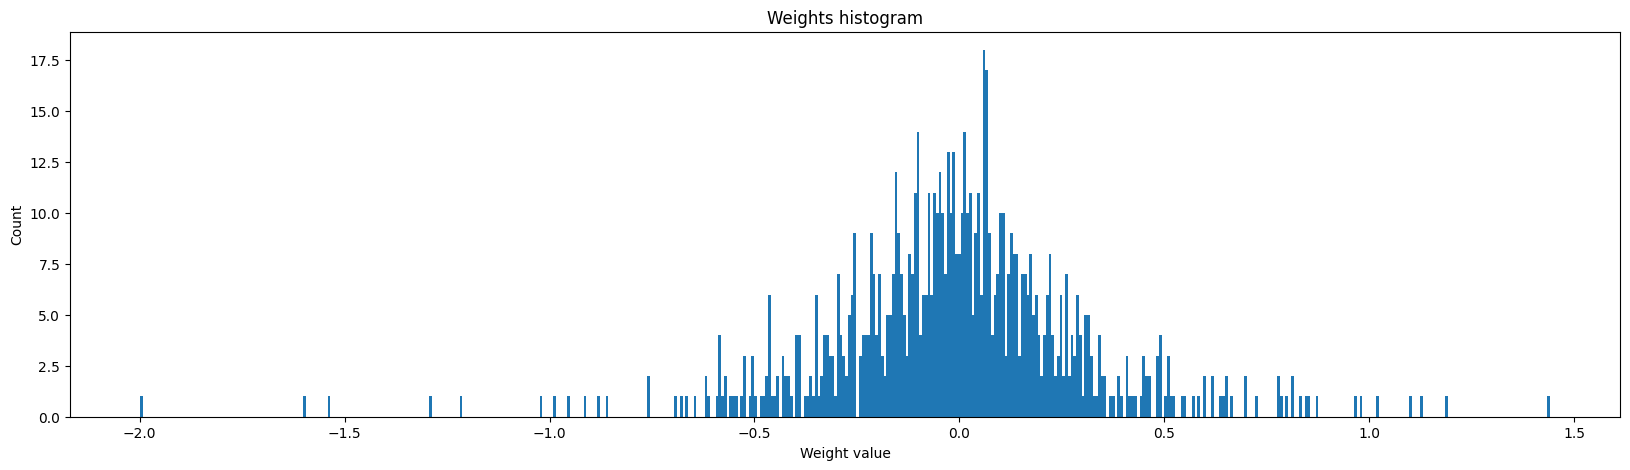

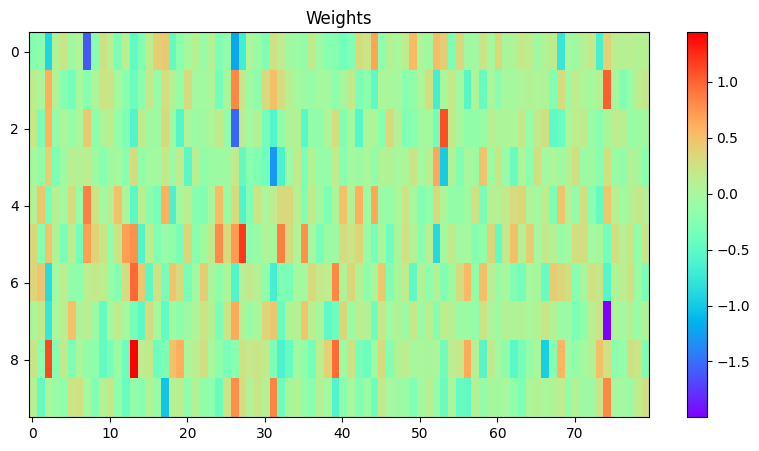

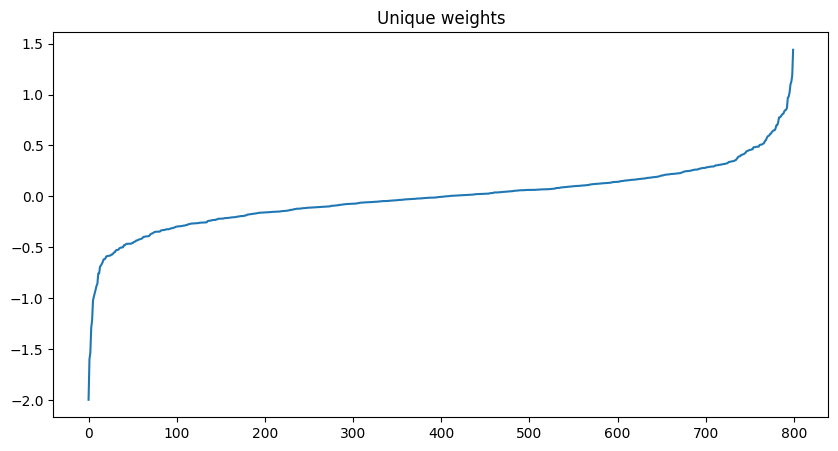

In [15]:
weights = rnn.linear_000.linear.weight.detach().cpu().numpy()
f, ax = plt.subplots(1, 1, figsize=(20, 5))
ax.hist(weights.flatten(), bins=512)
ax.set_title("Weights histogram")
ax.set_xlabel("Weight value")
ax.set_ylabel("Count")

f, ax = plt.subplots(1, 1, figsize=(10, 5))
im = ax.imshow(weights, cmap="rainbow", aspect="auto")
plt.colorbar(im, ax=ax)
ax.set_title("Weights")

unique = np.unique(weights)
unique.sort()
f, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(unique)
ax.set_title("Unique weights")
plt.show()

In [16]:
for x in weights.flatten():
    print(2**(7) * x)
    print(np.log2(x))
    break

-29.626850128173828
nan


/tmp/ipykernel_1391445/1335275174.py:3: RuntimeWarning: invalid value encountered in log2
  print(np.log2(x))


In [17]:
from torchmetrics import ConfusionMatrix

test_loader = DataLoader(
    test_set,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    collate_fn=collate_fn,
)


confmat = ConfusionMatrix(task="multiclass", normalize='true', num_classes=N_CLASSES, ).to(DEVICE)
confmat.reset()


# rnn.to(DEVICE)
# rnn.eval()
for batch in test_loader:
    mfcc, label = batch
    # print(mfcc.dtype)
    # mfcc = mfcc.to(torch.device("cpu"))
    # label = label.to(DEVICE)

    with torch.no_grad():
        pred = rnn(mfcc)

    confmat.update(pred, label)


matrix = confmat.compute().cpu().numpy()



[0.88095236 0.64285713 0.5        0.64285713 0.7380952  0.64285713
 0.33333334 0.88095236 0.6904762  0.52380955]


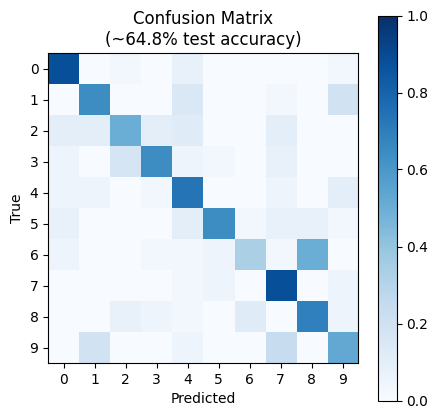

In [18]:

# get main diagonal
diag = matrix.diagonal()
print(diag)
# print(matrix)
fig, ax = plt.subplots(figsize=(5, 5))

im = ax.imshow(matrix, interpolation='nearest', cmap=plt.cm.Blues, vmin=0, vmax=1)
ax.set_title(f"Confusion Matrix\n(~{100*diag.mean():.1f}% test accuracy)")
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_xticks(range(N_CLASSES))
ax.set_yticks(range(N_CLASSES))
ax.set_xticklabels(range(N_CLASSES))
ax.set_yticklabels(range(N_CLASSES))
plt.colorbar(im, ax=ax)
plt.show()